In [1]:
import pygplates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
from pandas import Series,DataFrame
import seaborn as sns

%load_ext autoreload
%autoreload 2


In [2]:
from gprm.datasets import Reconstructions
Y2019 = Reconstructions.fetch_Young2019()
Y2019


pygmt-session [WARNING]: Representation of font type not recognized. Using default.
pygmt-session [WARNING]: Representation of font type not recognized. Using default.
pygmt-session [WARNING]: Representation of font type not recognized. Using default.
begin [WARNING]: Representation of font type not recognized. Using default.
begin [WARNING]: Representation of font type not recognized. Using default.
begin [WARNING]: Representation of font type not recognized. Using default.


Name: Young++2019
Rotation Files:
   - Global_410-250Ma_Young_et_al.rot
   - Global_250-0Ma_Young_et_al.rot
Static Polygon Files:
   - Global_GPlates_PresentDay_StaticPlatePolygons_Young_et_al.shp
Coastlines Files:
   - Global_coastlines_Young_et_al_low_res.shp
Continent Polygon Files:
   - PresentDay_ContinentalPolygons_Young_et_al.shp
Dynamic Polygon Files:
   - Global_Mesozoic-Cenozoic_plate_boundaries_Young_et_al.gpml
   - Global_Paleozoic_plate_boundaries_Young_et_al.gpml
   - TopologyBuildingBlocks_Young_et_al.gpml

In [3]:
df_ABC = pd.read_excel('data/DZDB4.xlsx',sheet_name="Samples")
print(df_ABC.columns)

df_ABC['FROMAGE'] = '0'
df_ABC['TOAGE'] = '0'
for i in range(len(df_ABC['FROMAGE'])):
    df_ABC.loc[i,('FROMAGE')] = df_ABC.loc[i,('Est. Depos. Age (Ma)')] + 4.99
    df_ABC.loc[i,('TOAGE')] = df_ABC.loc[i,('Est. Depos. Age (Ma)')] - 5

A_dataframe_EstD = df_ABC[df_ABC['type']=='A']
B_dataframe_EstD = df_ABC[df_ABC['type']=='B']
C_dataframe_EstD = df_ABC[df_ABC['type']=='C']


Index(['Sample_No.', 'Ref_Number', 'Ref_Sample_Key',
       'Ref No. In_Source_Database', 'Sample No. In_Source_Database',
       'Source_Database', 'Published Sample_ID', 'Country/State', 'Region',
       'Continent', 'Major Geographic-Geologic Description',
       'Minor Geologic-Geographic Unit', 'Locality', 'Latitude', 'Longitude',
       'Max. Depos. Age (Ma)', 'Est. Depos. Age (Ma)', 'Min. Depos. Age (Ma)',
       'Mineral', 'Mass Spectrometer', 'Spectrometer Location', 'Institution',
       'Spectrometer Model', 'Class-1 Rock Type', 'Class-2 Rock Type',
       'Class-3 Rock Type', 'Felsic/Mafic', 'Max Latitude', 'Min Latitude',
       'Max Longitude', 'Min Longitude', 'U-Pb Record Count',
       'U-Pb Record Count Standard_Model_Age', 'type', 'colour', 'FROMAGE',
       'TOAGE', 'distance_subduction', 'distance_subduction_m2016',
       'distance_Sengor_Natalin_rifts', 'distance_passive_margin_rifts',
       'distance_SN_PM_rifts', 'distance_active', 'distance_inactive',
       

In [4]:
len(df_ABC)

6066

In [5]:
a = df_ABC[df_ABC['Est. Depos. Age (Ma)']==0]
len(a)

1201

C:\Users\84746\anaconda3\envs\pygmt\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 38.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\84746\anaconda3\envs\pygmt\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 49.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\84746\anaconda3\envs\pygmt\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 36.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\84746\anaconda3\envs\pygmt\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 34.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\84746\anaconda3\envs\pygmt\lib\site-packages\seabor

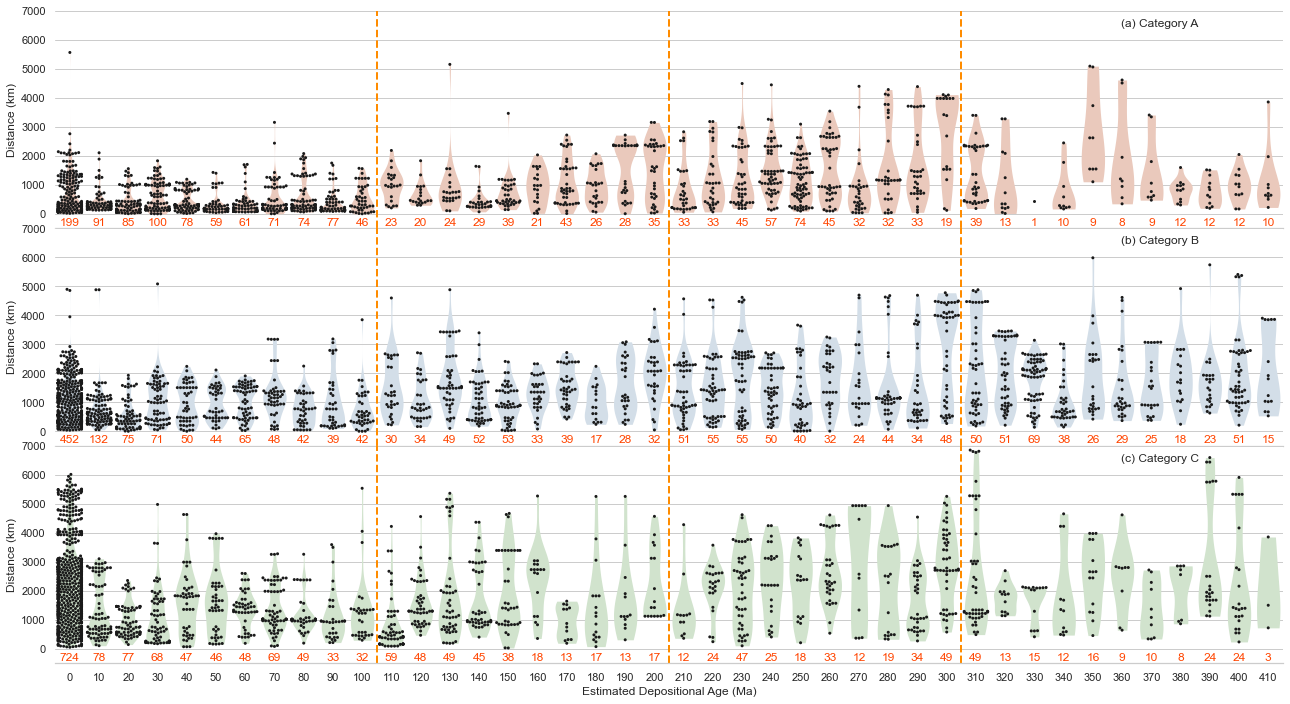

In [9]:
import cartopy.crs as ccrs
import statsmodels.api as sm # recommended import according to the docs

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(22,12))
fig.subplots_adjust(hspace=0)

types_names = ['(a) Category A', '(b) Category B', '(c) Category C']
colors = ['Reds_r','Blues_r','Greens_r']
color = ['#F2C6B4','#CFDEEC','#CFE6CA']
#color = ['#F8E0D5','#E0EAF3','#E5F1E1']
#colors = ['autumn','winter','summer']

dataframe_EstD = [A_dataframe_EstD, B_dataframe_EstD, C_dataframe_EstD]
for i in range(3):
    ax[i].set_title(types_names[i],x = 0.9, y = 0.9)
    dfE=dataframe_EstD[i]
    outcome = DataFrame()
    
    min_times = [ 0.,   5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.,
           105., 115., 125., 135., 145., 155., 165., 175., 185., 195., 205.,
           215., 225., 235., 245., 255., 265., 275., 285., 295., 305., 315.,
           325., 335., 345., 355., 365., 375., 385., 395., 405.] 
    max_times = [  5.,  15.,  25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105.,
           115., 125., 135., 145., 155., 165., 175., 185., 195., 205., 215.,
           225., 235., 245., 255., 265., 275., 285., 295., 305., 315., 325.,
           335., 345., 355., 365., 375., 385., 395., 405., 410.]
    xlabels=np.arange(0,420.,10)
    for ii, min_time in enumerate(min_times):
        if min_time <= 395:
            rd = dfE[np.logical_and(dfE['Est. Depos. Age (Ma)'] >= min_time , dfE['Est. Depos. Age (Ma)'] < max_times[ii] )]
            #rd['distance_subduction'] = rd['distance_subduction'].astype('float')
            data = rd[['distance_subduction']] 
            data = data.rename(columns={'distance_subduction':'Distance (km)'})
            #data['Estimated Depositional Age (Ma)'] = '{:d}$-${:d}'.format(int(min_time), int(max_times[ii]))
            data['Estimated Depositional Age (Ma)'] = '{:d}'.format(int(xlabels[ii]))
            data['order'] = max_times[ii]
            data = data.reset_index(drop=True)
            outcome = outcome.append(data)
        else:
            rd = dfE[np.logical_and(dfE['Est. Depos. Age (Ma)'] >= min_time , dfE['Est. Depos. Age (Ma)'] <= max_times[ii] )]
            #rd['distance_subduction'] = rd['distance_subduction'].astype('float')
            data = rd[['distance_subduction']] 
            data = data.rename(columns={'distance_subduction':'Distance (km)'})
            #data['Estimated Depositional Age (Ma)'] = '{:d}$-${:d}'.format(int(min_time), int(max_times[ii]))
            data['Estimated Depositional Age (Ma)'] = '{:d}'.format(int(xlabels[ii]))
            data['order'] = max_times[ii]
            data = data.reset_index(drop=True)
            outcome = outcome.append(data)

    outcome = outcome.reset_index(drop=True)
    #print(outcome['Estimated Depositional Age (Ma)'].to_list())
    #sns.swarmplot(y ='Distance (km)', x='Estimated Depositional Age (Ma)', data = outcome, color =color[i], size =3, alpha = 1, ax = ax[i])
    sns.violinplot(y='Distance (km)', x='Estimated Depositional Age (Ma)', inner=None, linewidth = 0, 
                   #palette=colors[i], 
                   color=color[i], 
                   data=outcome, cut=0, scale='width', ax = ax[i])

    sns.swarmplot(y ='Distance (km)', x='Estimated Depositional Age (Ma)', data = outcome, color ='k', size =3, alpha = 1, ax = ax[i])
    
    
    sns.despine(left=True)
    ax[i].set_ylim(-500,7000)
    #ax[i].axvline(0.5,c="DarkOrange", ls="--", lw=2)
    ax[i].axvline(10.5,c="DarkOrange", ls="--", lw=2)
    ax[i].axvline(20.5,c="DarkOrange", ls="--", lw=2)
    ax[i].axvline(30.5,c="DarkOrange", ls="--", lw=2)
    
    #medians = outcome.groupby(['Estimated Depositional Age(Ma)'])['Distance(km)'].median().values
    nobs = outcome['order'].value_counts(sort=False).sort_index().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = [i for i in nobs]
    pos = range(len(nobs))
    #print(ax[i].get_xticklabels())
    #for tick,label in zip(pos,ax[i].get_xticklabels()):
        #ax[i].text(pos[tick],0-300, nobs[tick], horizontalalignment='center', size='large', color='OrangeRed', weight='semibold')
    for tick in pos:
        ax[i].text(pos[tick],0-400, nobs[tick], horizontalalignment='center', size='medium', color='OrangeRed')
        
#plt.savefig('plots/figures/fig4.pdf', dpi=1000)
plt.savefig('plots/figures/Figure5.png', dpi=600)
plt.savefig('plots/figures/Figure5.pdf')

plt.show()